In [ ]:
# The code refers from segment anything project https://github.com/facebookresearch/segment-anything

# Automatically generating object masks with MobileSAM

Since MobileSAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. 

In [1]:
import sys

In [2]:
if 'google.colab' in sys.modules:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture2.jpg
        
    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt


## Set-up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
def remove_overlapped_masks(masks, threshold):
    masks_to_keep = masks.copy()
    indices_to_remove = set()
    mask_areas = [np.sum(mask['segmentation']) for mask in masks_to_keep]

    num_masks = len(masks_to_keep)
    
    # Iterar sobre cada par de máscaras
    for i in range(num_masks):
        for j in range(i + 1, num_masks):
            mask_i = masks_to_keep[i]
            mask_j = masks_to_keep[j]

            # Verificar si las máscaras se superponen
            overlap = mask_i['segmentation'] & mask_j['segmentation']

            if np.any(overlap):
                # Calcular el porcentaje de superposición
                overlap_percentage_i = np.sum(overlap) / mask_areas[i]
                overlap_percentage_j = np.sum(overlap) / mask_areas[j]

                # Si el porcentaje de superposición es mayor que el umbral, decidir cuál máscara mantener
                if overlap_percentage_i > threshold or overlap_percentage_j > threshold:
                    if mask_areas[i] < mask_areas[j]:
                        indices_to_remove.add(j)
                    else:
                        indices_to_remove.add(i)
    
    # Construir lista de máscaras a mantener
    masks_to_keep = [mask for idx, mask in enumerate(masks_to_keep) if idx not in indices_to_remove]

    return masks_to_keep

In [ ]:
def convertir_a_json(objeto):
    if isinstance(objeto, np.ndarray):
        return objeto.tolist()  # Convertir ndarray a lista
    raise TypeError(f"Tipo {type(objeto)} no serializable")

In [5]:
image_path = 'content/cam_sup_l_.*.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if(image is None):
    print("Image not found")

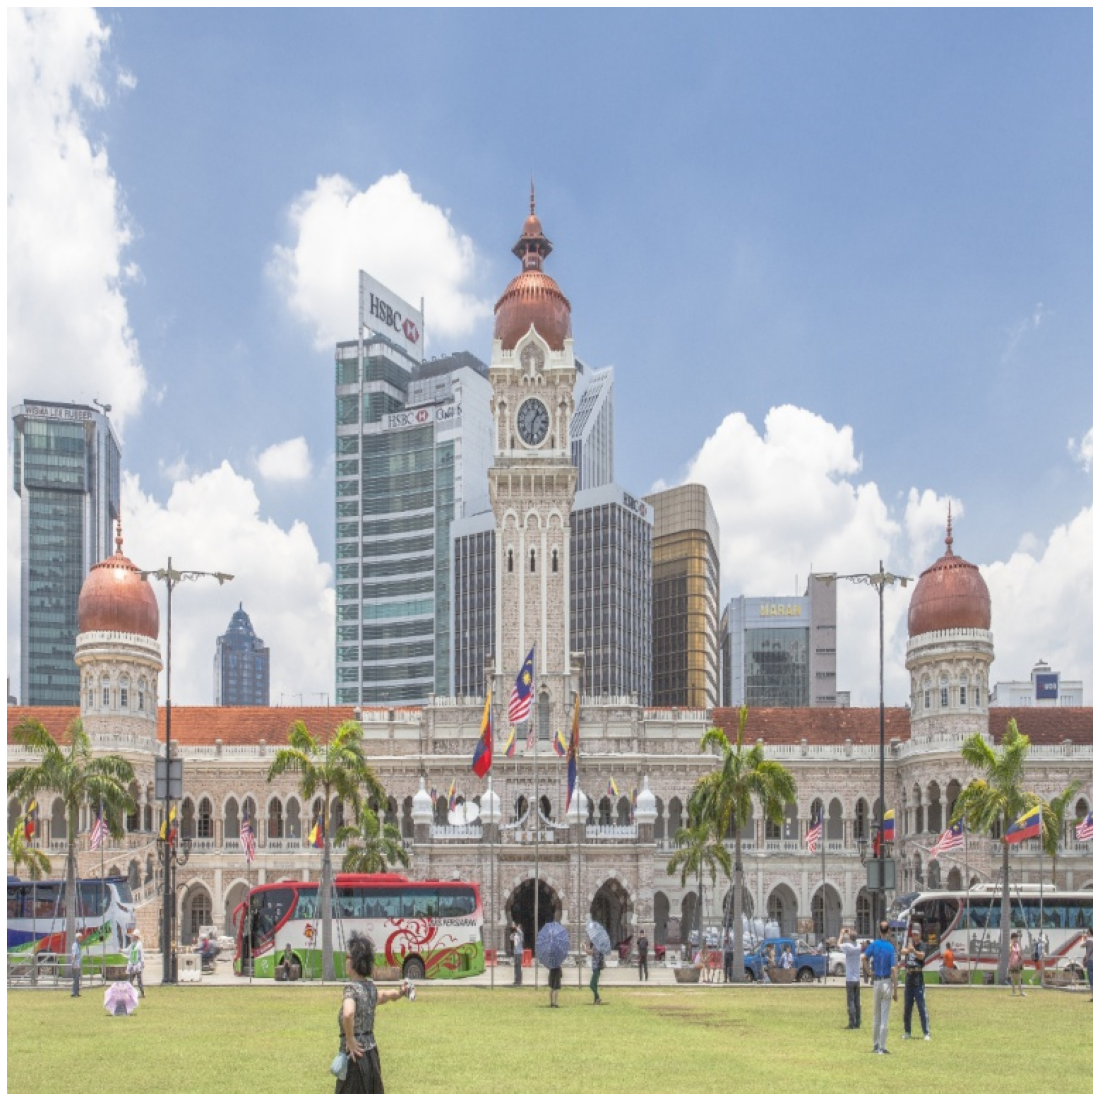

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [13]:
masks = mask_generator.generate(image)masks = mask_generator.generate(image)
masks_to_keep = []

for mask in masks: # Añadir el número de cuadrante a cada máscara
    area = mask['area']
    if area <= 4800: #Se filtran por altura
        masks_to_keep.append(mask)

In [ ]:
masks_to_keep = remove_overlapped_masks(masks_to_keep, 0.2)

In [14]:
len(masks)

213

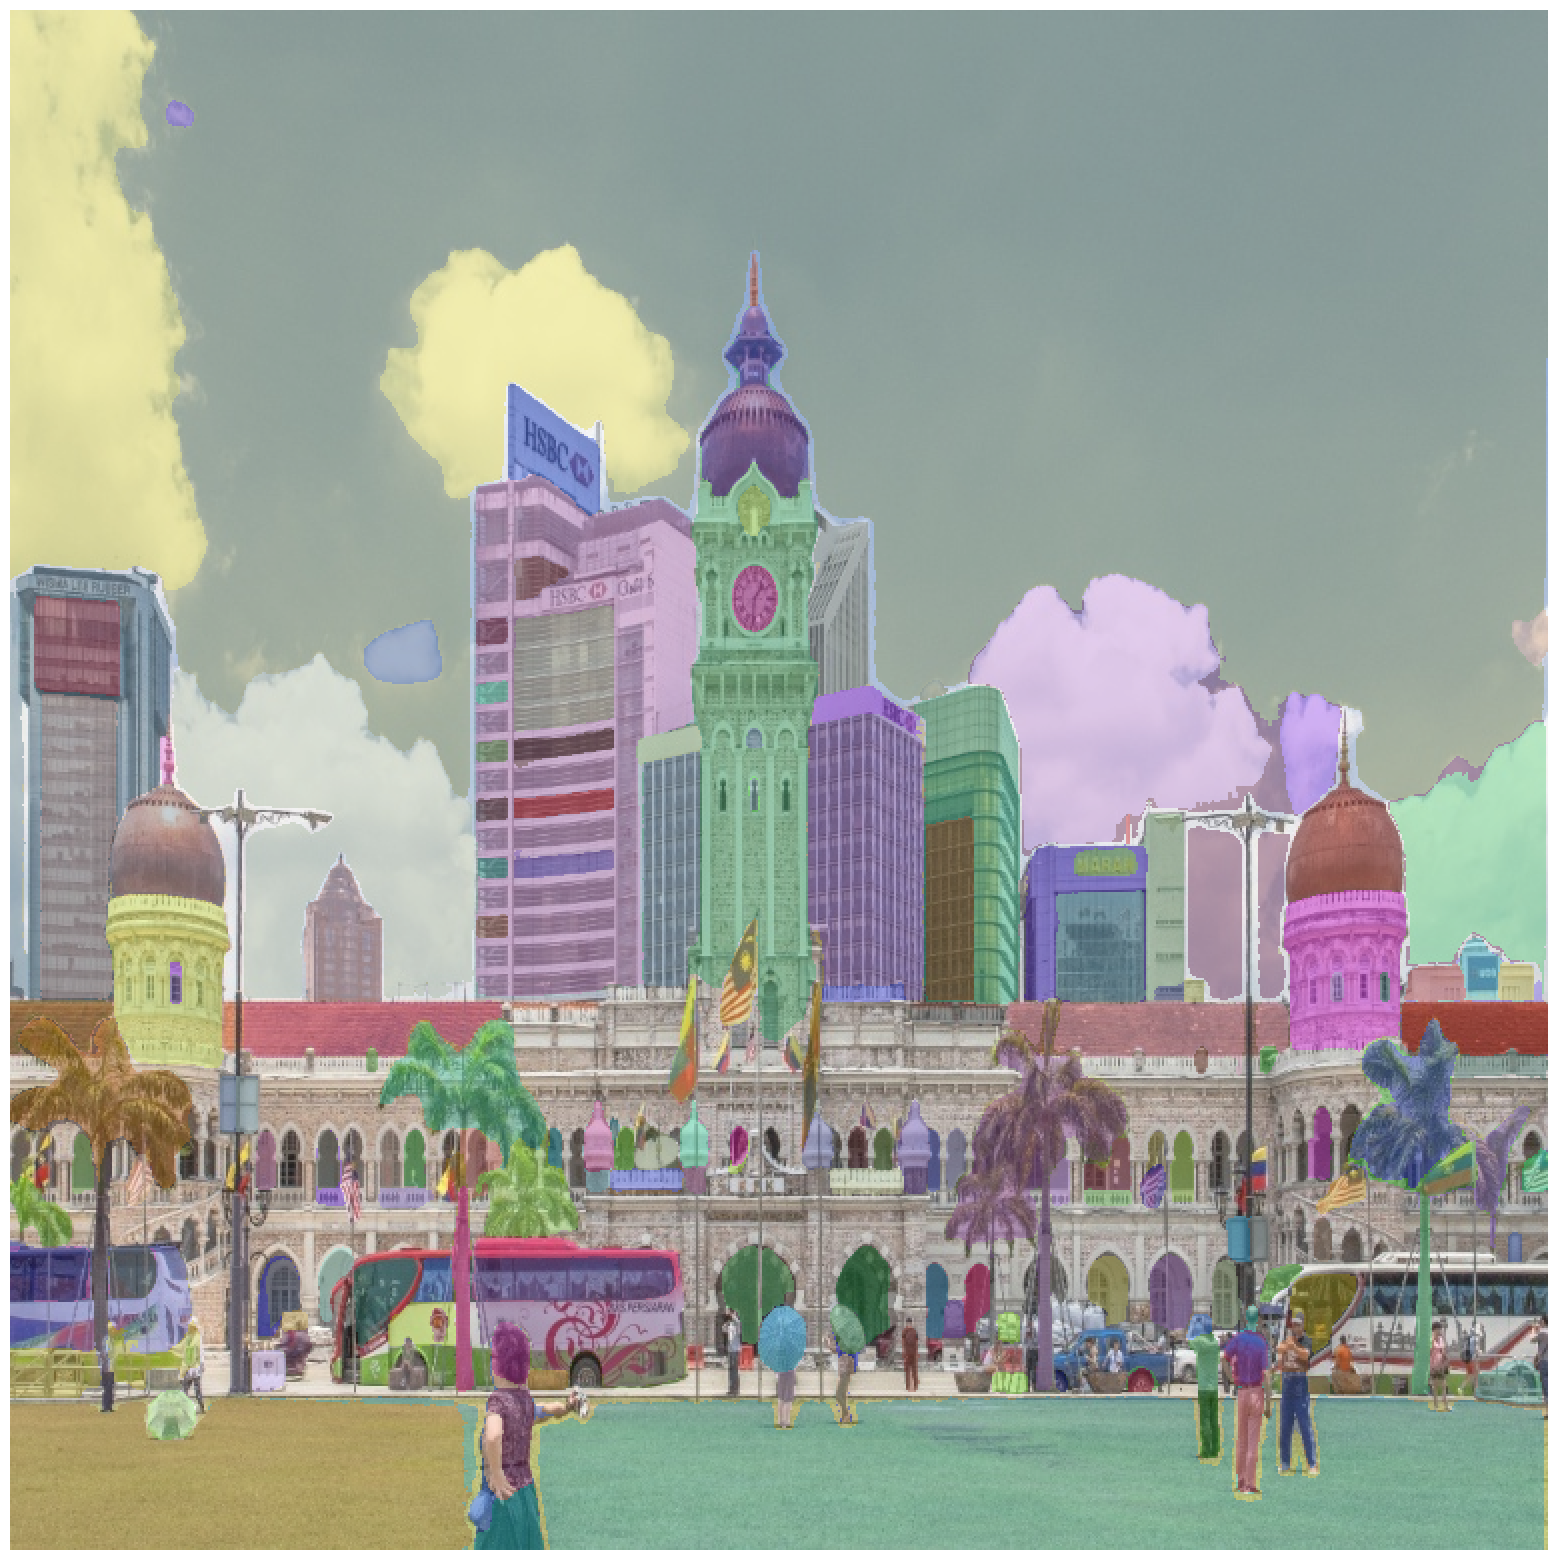

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
import json
import os

#el sufijo es lo que está después de la última barra en el nombre de la imagen cuyo formato es "cam_sup_l_sufijo.jpg"
#extrae el sufijo en función del nombre de la imagen
image_name = os.path.basename(image_path)
sufijo = int(image.split('_')[-1].split('.')[0])

# Lista de bounding boxes y áreas para las máscaras del lado izquierdo
mask_list = []
for mask in masks_to_keep:
    mask_list.append({
        'bbox': mask['bbox'],
    })

#Guardar los datos de las máscaras en un .json
with open(f'masks/masks_{sufijo}.json', 'w') as archivo_json:
    json.dump(mask_list, archivo_json, default=convertir_a_json, indent=4)